# PyTorch: Tensor Ops

This notebook covers the very basics of using PyTorch. 

In [ ]:
from __future__ import print_function
import torch
import numpy as np
%pylab inline

import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION:')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
__Python VERSION: 3.10.10 (tags/v3.10.10:aad5f6a, Feb  7 2023, 17:20:36) [MSC v.1929 64 bit (AMD64)]
__pyTorch VERSION: 2.5.1+cu124
__CUDA VERSION
__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


'nvcc' is not recognized as an internal or external command,
operable program or batch file.


The pylab command above inputs lots of numpy stuff -- I am unsure if you have pylab installed on your WSU provided machines. Anyway, it is equivalent to importing all functions and objects from numpy and matplotlib.

Torch implements its own set of datatypes, the most important of which is a Tensor. 

### Tensors

In [4]:
x = torch.Tensor(5, 3)
print(x)

x = torch.rand(2,2,2,1)
print(x)

tensor([[3.8706e+25, 2.0081e-42, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[[[0.8877],
          [0.0137]],

         [[0.5451],
          [0.0204]]],


        [[[0.0672],
          [0.3024]],

         [[0.3369],
          [0.8702]]]])


Note that torch.Tensor yields an <i>uninitialized</i> tensor with dimensions specified. The parameters specify the size of each dimension of the tensor, and you can specify as many dimensions as you like. By default a tensor is a FloatTensor that holds 32-bit floats. There are tensors for other data types: torch.float64, torch.float16, .uint8, .int16, .int32, .int64.

You can also pass in data that you want to put in a tensor.

In [ ]:
## Even though I pass in a multidimensional list of int's, torch.Tensor always gives me a FloatTensor.
x = torch.Tensor([[1, 1, 1,1],[2,2,2,2],[3,3,3,3],[4,4,4,4]])
print(x)

x = torch.zeros(4,4)
print(x) 

x = torch.ones(2,2)
print(x) 

Check out everything you can do with Tensors here: https://pytorch.org/docs/stable/torch.html

<b>First super cool thing about PyTorch:</b> it is trivial to translate a pytorch tensor to a numpy ndarray, and vice versa. (numpy ndarray's are a most often used data type for loading and reading numeric data in Python).

In [ ]:
x = torch.Tensor([[1,1,1],[2,2,2],[3,3,3]])

## From pytorch to numpy: 
y = x.numpy()
print(x)
print(y)
print(type(y))

## from numpy to pytorch: just pass a numpy ndarray in! 
z = torch.Tensor(y)
print(z)

## element-wise comparison of FloatTensors y and z...
y==z

**Indexing tensors**: Pytorch tensors support numpy like indexing of tensors. For example:

In [ ]:
## x will be a 2x4x4 tensor: the first dimension has 2 elements, each of which is a 4x4 matrix.
x = torch.Tensor([
                  [[1,1,1,1],
                   [2,2,2,2],
                   [3,3,3,3],
                   [4,4,4,4]],
                  
                  [[10,10,10,10],
                   [20,20,20,20],
                   [30,30,30,30],
                   [40,40,40,40]]
    
                ])
print(x)
## x.shape will get you an indexible list of the shape of a tensor.
print(x.shape[0])
print(x.shape[1])
print(x.shape[2])

## Slice and dice the tensor! Remember that tensors are 0 based, and the notation 
## a:b 
## means to fetch elements in indices starting from a and up to (but not including) b.

# All elements in the first index of the first dimension of x
print(x[0,:,:])
# Elements in rows 1, 2, 3 and col 1, 2, 3 of the first index of the first dimension of x
print(x[0,1:4,1:4])
# Elements in all rows starting from the 3rd and all columns until the 2nd of the first dimension of x
print(x[0,2:,:2])
# Elements in all rows starting from the 4rd and all columns until the 1st of the first dimension of x
print(x[0,3:,:1])
# Elements in rows 2 and 3 and all columns of the second dimension of x
print(x[1,1:3,:])

### Practice slicing and dicing, this is important! Think of a subtensor and device a way to slice it. 
print(x[:-1,:,:])

## GPU Computing

<b> Why GPU computing?? </b>
<ol>
    <li> GPUs have more computing cores (GTX 1080ti: 2560 cores; intel i7 CPU: 8 cores?), alebit slower than a CPU
    <li> GPUs have an extremely fast bus between GPU and on-board video card memory, typically 3-4x faster than bus between CPU and RAM
    <li> GPUs have custom built libraries (e.g. CUDA) for ultra-efficient numerical computation
</ol>
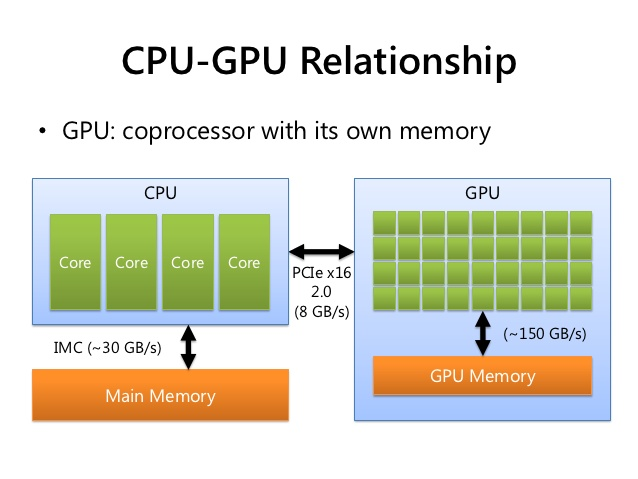

<b> Key Weakness: </b> It is <b>expensive</b> to transfer data between RAM and GPU memory. GPUs operate on instructions given by a CPU, but all of the data a GPU operates on must be stored in GPU memory. It is an <i>expensive</i> path for data to travel from RAM --> CPU --> bus --> PCIe interface --> bus --> GPU and back.
**Even a modern PCIe interface is about twice as slow as busses from RAM to CPU.**

Therefore, when we compute on GPUs, we want to be sure that all variables and data we need are loaded into GPU memory prior to code execution. We should <b>never</b> run an operation on data that lives in both main memory and GPU memory. For example, adding a Tensor in RAM with a Tensor in GPU memory is going to be slow and inefficient.
If you are doing operations between objects in RAM and in GPU in loops in long executions, expect a 2-3x performance drop! 

<b>I will assume that PyTorch is configured to work with CUDA on the video card of your system. </b> If you are using the ATRC GPU compute nodes this is satisfied. So note that none of this will work on ATI video cards! 

It is trivial to create a tensor onto the GPU:

In [ ]:
x = torch.cuda.FloatTensor([[1,1,1],[1.5,1.5,1.5],[2.1,2.2,2.3]])
print(x)

We see the float tensor was assigned to GPU 0. Most any type of tensor can be moved to a gpu by prepending cuda. to its instantiation. 

If you are running on a node with multiple GPUs (and indeed some of our machines have more than one video card, you can explicitly assign what device the tensor should go to with the device parameter (devices are 0-indexed):

In [ ]:
x = torch.cuda.FloatTensor([[1,1,1],[1.5,1.5,1.5],[2.1,2.2,2.3]], device=1)
print(x)

You can also move a tensor from RAM to GPU memory by calling .cuda() on the tensor:
(also look up .cpu and .to)

In [ ]:
y = torch.rand(5,3)
print(y)
x = y.cuda()
print(x)

**Performance Comparison:**

In [ ]:
from timeit import default_timer as timer

## multiply two matrices with 10,000,000 entries
x = torch.rand(10000,1000)
y = torch.rand(1000,10000)
start = timer()
torch.mm(x,y)
end = timer()
print('time to matrix multiply 2 tensors in RAM:',end - start)

a = x.cuda()
b = y.cuda()

start = timer()
z = x.cuda() 
torch.mm(z,b) ##PyTorch forces you to move x to the GPU before running matrix multiplication.
end = timer()
print('time to matrix multiply 2 tensors, one in RAM one in GPU memory:',end - start)

start = timer()
torch.mm(a,b)
end = timer()
print('time to matrix multiply 2 tensors in GPU memory:',end - start)


There are tons of math ops you can do on Tensors; see <a href="https://pytorch.org/docs/stable/torch.html?highlight=tensor#math-operations"> this link </a> for a complete list. We enumerate over some of them here. 

In [ ]:
x = torch.Tensor([[1,1,1],[2,2,2],[3,3,3]])
print("X")
print(x)

### Note that x.add(1) returns a tensor that has 1 added to every element of x. It does <b>not</b> update x in place.
x.add(1)
print("x.add(1)")
print(x)

### Note: adding the _ suffix to many tensor ops will cause the op to occur in place.
x = x.add_(1)
print("x.add_(1)")
print(x)

print("x+1")
print(x+1)

## Important: Tensor multiplication via * is the hadamard product (component wise multiplication). 
x = torch.Tensor([0.5,0.5,0.5])
y = torch.Tensor([2, 4, 6])
print(x*y)

## Matrix multiplication is achieved by mm
print(torch.mm(x,y))

**Reshaping Tensors:** Note that the matrix multiplication failed because x and y are 3x1 tensors. We can easily reshape tensors to transfer their elements into a tensor with new dimension. In numpy we have the **reshape** function, in PyTorch this is called the **view** function.

In [ ]:
y = torch.Tensor([2, 4, 6, 8])
print(y.view(2,2))
print(y.view(1,4))
print(y.view(4,1))
print(y.view(2,2,1))
print(y.view(2,1,2))
print(y.view(1,2,2))
print(y.view(1,2,1,2))

# -1 figures out the dimension size automatically
print(y.view(-1, 2))

x = torch.Tensor([[0.5,0.5],[0.5,0.5]])
print(torch.mm(x,y.view(2,2)))

In [ ]:
## Random Sampling Ops. I fix the random sampling seed to get consistent results. 
torch.manual_seed(1234)

## Get a tensor of numbers drawn from the uniform distribution over [0,1]
y = torch.rand(5,3)
print(y)

## Sample from bernoulli dist. Input tensor is the parameter p for each draw. Output is same size as input tensor.
print(torch.bernoulli(y))

## Changing seed just to show affect on random samples
torch.manual_seed(2345)
print(torch.bernoulli(y))

## Sample from normal distribution. Param 1: tensor of means, Param 2: tensor of variance terms.
## output: a tensor whose entry ij is a draw from a normal with mean p1_ij and variance p2_ij.
print(torch.normal(y, torch.rand(5,3)))

x = torch.Tensor([[1,1,1],[2,2,2],[3,3,3]])
print('exponential:', torch.exp(x))

x = torch.Tensor([0.5,0.5,0.5])
print(2*x)



**Redution methods** tend to be really useful for deep learning.

In [ ]:
x = torch.Tensor([[2.0,3.4,5.3,1.1],
                  [4.3,1.2,6.6,2.3],
                  [8.9,0.2,0.1,9.9]])
print(x)
print(torch.max(x))

## Get the max value and index of max value along the each dimension of tensor x.
## dim 0: Rows. So get the max value of index 0 of all rows, index 1 of all rows, etc. 
max_val, arg_max = torch.max(x,0)
print(max_val,arg_max)

## dim 1: Cols. So get the max value of index 0 of all columns, index 1 of all cols, etc. 
max_val, arg_max = torch.max(x,1)
print(max_val,arg_max)

## dim 2: depth
x = torch.Tensor([[[2.0,3.4,5.3,1.1],
                  [4.3,1.2,6.6,2.3],
                  [8.9,0.2,0.1,9.9]]])
x.shape
max_val, arg_max = torch.max(x,2)
print(max_val,arg_max)

min_val, arg_min = torch.min(x,1)
print('min val and arg min:', min_val,arg_min)

print(x)
print('top-k values along the second dimension of x, with indices:', torch.topk(x,k=2,dim=1))

Author: Derek Doran, ATRC Summer 2018

In [3]:
print("Torch version:",torch.__version__)

print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.5.1+cu124
Is CUDA enabled? True
